В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm_bright_test = ListedColormap(['#FFA833','#33E0FF']) # '5EFF33', '#FFF933'
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

np.random.seed(1)

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y, color_map=cm_bright):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=color_map)

In [4]:
class DeepNeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layer_dims, normalize = True, learning_rate = 0.01, num_iter = 30000, precision = None):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.precision = precision
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    
    
    def __initialize_parameters(self):
        layer_dims = self.layer_dims
        parameters = {}
        L = len(layer_dims)

        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        self.parameters = parameters

    def __forward_linear_activation(self, A_prev, W, b):
        
        # linear forward
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
    
        # activation forward
        A = self.__sigmoid(Z)
        activation_cache = Z
        
        cache = (linear_cache, activation_cache)

        return A, cache
    
    def __multilayer_forward(self, X):       
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1, L):
            A_prev = A 
            A, cache = self.__forward_linear_activation(A_prev, parameters["W"+str(l)], parameters["b"+str(l)])
            caches.append(cache)
            
        AL, cache = self.__forward_linear_activation(A, parameters["W"+str(L)], parameters["b"+str(L)])
        caches.append(cache)
        
        assert(AL.shape == (1,X.shape[1]))

        return AL, caches

    def __backward_linear_activation(self, dA, cache):
        
        linear_cache, activation_cache = cache
        
        # activation backward
        Z = activation_cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        
        # linear backward
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = 1 / m * np.dot(dZ, A_prev.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        
        return dA_prev, dW, db


    def __multilayer_backward(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__backward_linear_activation(dAL, current_cache)
        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__backward_linear_activation(grads["dA" + str(l + 1)], current_cache)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
            
        return grads
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __update_parameters(self, grads):
        parameters = self.parameters;
        learning_rate = self.learning_rate
        L = len(parameters) // 2

        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
            
        self.parameters = parameters;
        

    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):

            AL, caches = self.__multilayer_forward(X)
            
            cost = self.compute_cost(AL, Y)
            
            grads = self.__multilayer_backward(AL, Y, caches)
            
            self.__update_parameters(grads)
            
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
                
                if len(costs) > 1 and self.precision != None and np.abs(costs[-2] - costs[-1]) < self.precision:
                    print('Stopping gradient descent ...')
                    break

        if print_cost:
                plt.plot(costs)
                plt.ylabel("Cost")
                plt.xlabel("Iteration, *100")
                plt.show()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__multilayer_forward(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("../Logistic Regression/data/tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


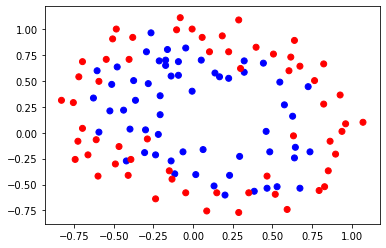

In [7]:
plot_data(X, Y)

In [8]:
#cls = DeepNeuralNet(layer_dims = [2,2,1] , learning_rate = 0.5, num_iter = 4000)
#cls = DeepNeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 4000)
#cls = DeepNeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 10000)
cls = DeepNeuralNet(layer_dims = [2,20,6,1], normalize = True, learning_rate = 0.5, num_iter = 14000) # easy overfit

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

Cost after iteration 0: 0.692886
Cost after iteration 100: 0.689521
Cost after iteration 200: 0.689521
Cost after iteration 300: 0.689521
Cost after iteration 400: 0.689521
Cost after iteration 500: 0.689521
Cost after iteration 600: 0.689521
Cost after iteration 700: 0.689520
Cost after iteration 800: 0.689520
Cost after iteration 900: 0.689520
Cost after iteration 1000: 0.689520
Cost after iteration 1100: 0.689520
Cost after iteration 1200: 0.689520
Cost after iteration 1300: 0.689520
Cost after iteration 1400: 0.689520
Cost after iteration 1500: 0.689520
Cost after iteration 1600: 0.689519
Cost after iteration 1700: 0.689519
Cost after iteration 1800: 0.689519
Cost after iteration 1900: 0.689519
Cost after iteration 2000: 0.689519
Cost after iteration 2100: 0.689518
Cost after iteration 2200: 0.689518
Cost after iteration 2300: 0.689518
Cost after iteration 2400: 0.689517
Cost after iteration 2500: 0.689517
Cost after iteration 2600: 0.689517
Cost after iteration 2700: 0.689516
Cost

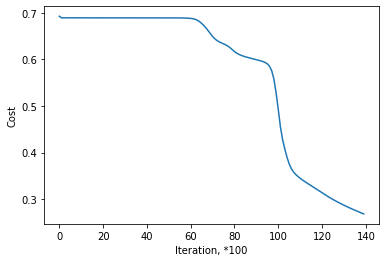

In [10]:
cls.fit(X_train, Y_train)

In [11]:
print(cls.parameters)

{'W1': array([[ 1.47230490e+00, -4.03200645e-01],
       [-6.05511348e-01, -7.92744572e-01],
       [ 7.14439096e-01, -8.95769854e-01],
       [ 6.23130099e-01,  4.08361512e+00],
       [-5.70464151e-01, -8.28471967e-01],
       [ 3.12502026e+00,  3.73239991e-01],
       [ 4.60067273e+00,  1.05641980e+00],
       [-8.96239153e-01,  1.14665549e+00],
       [-1.35620310e-01, -8.68724161e-01],
       [ 3.13516434e-01,  4.13003794e-01],
       [-4.77716276e+00, -3.06889208e+00],
       [-5.40311067e-01, -7.99680175e-01],
       [-2.11173677e-01, -9.73512079e-01],
       [-2.30382370e-01, -1.08263286e+00],
       [ 2.94645955e-01,  6.04205688e-01],
       [-2.84060197e+00,  1.88348488e+00],
       [-6.06540508e-01, -5.94171695e-01],
       [-4.39559332e-01,  3.46432034e-04],
       [-4.61907421e-01, -8.07161655e-01],
       [-9.33339606e-01,  1.23955640e+00]]), 'b1': array([[-0.27752661],
       [ 0.02923476],
       [ 2.04858021],
       [-5.93358511],
       [-0.08735392],
       [ 1.7867

In [12]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[9.48886899e-01, 5.11131014e-02],
       [9.86773609e-01, 1.32263905e-02],
       [9.98443145e-01, 1.55685450e-03],
       [2.15733090e-01, 7.84266910e-01],
       [5.45087349e-03, 9.94549127e-01],
       [6.79461476e-02, 9.32053852e-01],
       [9.81704123e-01, 1.82958769e-02],
       [2.02917311e-01, 7.97082689e-01],
       [1.08458524e-01, 8.91541476e-01],
       [5.20348577e-01, 4.79651423e-01],
       [5.39925391e-03, 9.94600746e-01],
       [1.08106347e-02, 9.89189365e-01],
       [1.78854329e-03, 9.98211457e-01],
       [1.04626271e-02, 9.89537373e-01],
       [4.44348320e-02, 9.55565168e-01],
       [5.80994200e-02, 9.41900580e-01],
       [3.13649845e-01, 6.86350155e-01],
       [9.76512383e-04, 9.99023488e-01],
       [8.23864580e-01, 1.76135420e-01],
       [7.20557042e-01, 2.79442958e-01],
       [6.02280391e-01, 3.97719609e-01],
       [8.92545825e-01, 1.07454175e-01],
       [3.94682584e-02, 9.60531742e-01],
       [1.08370701e-01, 8.91629299e-01],
       [1.015241

In [13]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

In [14]:
accuracy_score(Y_train, Y_train_hat)

0.851063829787234

In [15]:
accuracy_score(Y_test, Y_test_hat)

0.8333333333333334

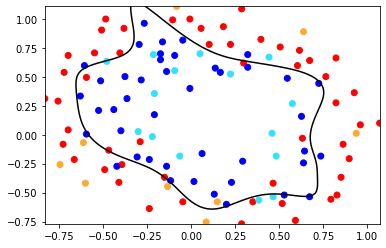

In [16]:
plot_data(X_train, Y_train.reshape((Y_train.shape[0],)))#_train
plot_data(X_test, Y_test.reshape((Y_test.shape[0],)), color_map = cm_bright_test)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [17]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [18]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

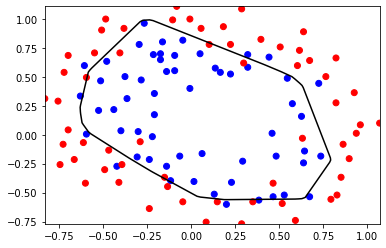

In [19]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [20]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306

In [ ]:
m.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
mean_squared_error(y_test, y_pred) 